### autoencoding

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
file_path = "/content/drive/MyDrive/code_sharing/syncopate/final100k.csv"
audio_featured_df = pd.read_csv(file_path, encoding='utf8')

In [15]:
audio_featured_df.columns

Index(['duration_ms', 'popularity', 'tempo', 'key', 'liveness', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'loudness', 'mode',
       'speechiness', 'time_signature', 'valence', 'is_title_contain_live',
       'high_liveness', 'incorrect_liveness'],
      dtype='object')

In [14]:
audio_featured_df = audio_featured_df.drop(['Unnamed: 0'], axis=1)


In [16]:
# seperate the data in X, Y
y_df = audio_featured_df['incorrect_liveness']
x_df = audio_featured_df.drop(['is_title_contain_live','high_liveness','incorrect_liveness'], axis=1)


In [17]:
x_df.columns

Index(['duration_ms', 'popularity', 'tempo', 'key', 'liveness', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'loudness', 'mode',
       'speechiness', 'time_signature', 'valence'],
      dtype='object')

In [21]:
x_df.shape

(99999, 14)

In [18]:
# transform the data by StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
x_df_MM = MinMaxScaler().fit_transform(x_df)

In [6]:
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
import numpy as np

In [22]:
from sklearn.model_selection import train_test_split
# train_test_split -> (特徵90%, 特徵10%, 目標90%, 目標10%)
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.1)

In [23]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((89999, 14), (89999,), (10000, 14), (10000,))

In [24]:
normal_no = 0
abnormal_no = 1

x_normal = x_train[y_train == normal_no]
x_test_normal = x_test[y_test == normal_no]
x_abnormal = np.concatenate((x_train[y_train == abnormal_no], x_test[y_test == abnormal_no]))

#x_normal = np.expand_dims(x_normal, axis=-1)
#x_test_normal = np.expand_dims(x_test_normal, axis=-1)
#x_abnormal = np.expand_dims(x_abnormal, axis=-1)

# For Dense autoencoder
x_normal = np.array(x_normal).reshape((x_normal.shape[0], -1))
x_test_normal = np.array(x_test_normal).reshape((x_test_normal.shape[0], -1))
x_abnormal = np.array(x_abnormal).reshape((x_abnormal.shape[0], -1))

In [25]:
x_normal.shape, x_test_normal.shape , x_abnormal.shape

((88234, 14), (9812, 14), (1953, 14))

Normalization

In [26]:
# Model 2: Dense encoder
inputs = Input((14,))
x = Dense(8, activation='tanh')(inputs)
x = Dense(4, activation='tanh')(x)
x = Dense(2, activation='tanh')(x)
x = Dense(4, activation='tanh')(x)
x = Dense(8, activation='tanh')(x)
x = Dense(14, activation='sigmoid')(x)
model = Model(inputs, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 120       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 14)                126   

In [27]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-4), loss='mse')

In [28]:
h = model.fit(x_normal, x_normal, batch_size=32, epochs=50)

Epoch 1/50
2758/2758 [==============================] - 3s 980us/step - loss: 4550403928.2407
Epoch 2/50
2758/2758 [==============================] - 3s 941us/step - loss: 4528893598.5734
Epoch 3/50
2758/2758 [==============================] - 3s 958us/step - loss: 4520343916.1899
Epoch 4/50
2758/2758 [==============================] - 3s 945us/step - loss: 4548113026.2733
Epoch 5/50
2758/2758 [==============================] - 3s 979us/step - loss: 4584296292.9525
Epoch 6/50
2758/2758 [==============================] - 3s 959us/step - loss: 4613544889.2033
Epoch 7/50
2758/2758 [==============================] - 3s 959us/step - loss: 4586388470.5357
Epoch 8/50
2758/2758 [==============================] - 3s 969us/step - loss: 4642350111.6404
Epoch 9/50
2758/2758 [==============================] - 3s 953us/step - loss: 4607962764.2015
Epoch 10/50
2758/2758 [==============================] - 3s 943us/step - loss: 4599331426.9112
Epoch 11/50
2758/2758 [==============================] - 3s

In [29]:
pred_normal = model.predict(x_test_normal)
pred_abnormal = model.predict(x_abnormal)
pred_train = model.predict(x_normal)

In [30]:
pred_normal.shape, pred_abnormal.shape, pred_train.shape

((9812, 14), (1953, 14), (88234, 14))

In [31]:
def mse(x, y):
    return (np.square(x - y)).mean(axis=(1))

In [32]:
error_normal = mse(pred_normal, x_test_normal)
error_abnormal = mse(pred_abnormal, x_abnormal)
error_train_normal = mse(pred_train, x_normal)

In [ ]:
error_normal.shape, error_abnormal.shape, error_train_normal.shape

((9856,), (1463,), (88680,))

In [33]:
np.mean(error_normal), np.mean(error_abnormal), np.mean(error_train_normal)

(4548888031.647074, 12292665726.843702, 4588813095.261304)

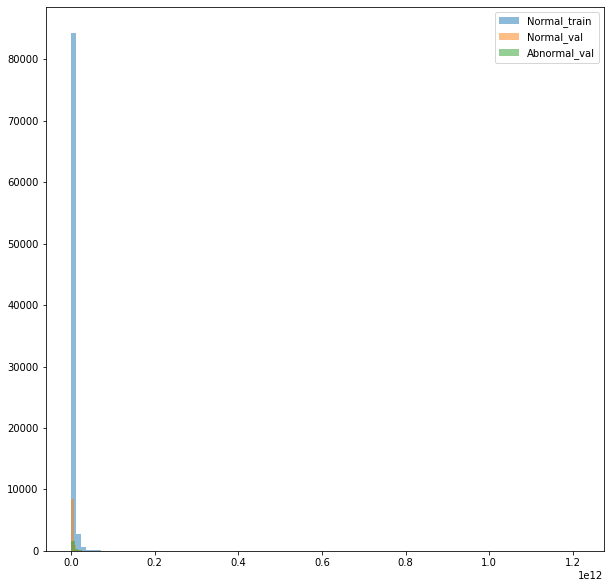

In [34]:
plt.figure(figsize=(10,10))
plt.hist(error_train_normal, bins=100, alpha=0.5) # Blue
plt.hist(error_normal, bins=100, alpha=0.5) # Orange
plt.hist(error_abnormal, bins=100, alpha=0.5) # Green
plt.legend(['Normal_train', 'Normal_val', 'Abnormal_val'])
plt.show()